# Basic BCNN for Kinship Detection
## *Kaggle Competition: Northeastern SMILE Lab - Recognizing Faces in the Wild*

###EE 298 Project of:
###Jose Lorenzo Capistrano, Eldion Vincent Bartolo and Jasper Ryan Bisnar

## Abstract:

This Jupyter Notebook is used to predict if two people share a kinship relationship or not based on their facial images.

The dataset can be found at
https://www.kaggle.com/c/recognizing-faces-in-the-wild
and consist of the following:

* 10,580 Images:
X Individuals, Y Families
* 3,598 Image Pairs for Training
* 5,310 Image Pairs for Testing
* Image size: 224 x 224 pixels

This is implemented in Google Colab with GPU runtime
## Table of Contents


1.   Import data set from Google Drive
2.   Show some examples of the dataset
3.   Import Necessary Packages
4.   Define Functions for Computing distances and Accuracy
5.   Define Functions for Local Response Normalization and Batch Normalization
6.   Define functions for reading images and csv file for relationships
7.   Define the Initial Model
8.   Create Checkpoints and Callbacks
9.   Create The Bilinear Convolutional Neural Network (BCNN)
10.  Train the Network
11.  Make Predictions


## Import data set from Google Drive

In [0]:
# Connect to google drive with authentication
from google.colab import drive
drive.mount('/content/gdrive')
PATH_OF_DATA = '/content/gdrive/"My Drive"/SMILE_LAB_dataset'  #change dir to your project folder
root_path = '/content/gdrive/My Drive/SMILE_LAB_dataset/'

# List all folders
!ls {PATH_OF_DATA}

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
 keras_facenet		 sub_detect_kinship.csv   train
 kin-detection		'submission 1.csv'	  train_relationships.csv
 Results		'submission 2.csv'	  train.zip
 sample_submission.csv	 test
 saved_models_weights	 test.zip


## Show some examples of the dataset

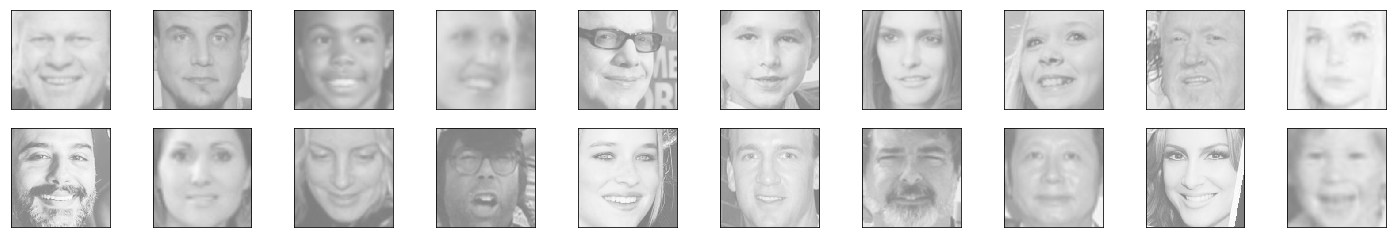

In [0]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
# Comment 0: define transformation that you wish to apply on image
data_transforms = transforms.Compose([
                    transforms.CenterCrop(224),
                    transforms.Grayscale(num_output_channels=3),
                    transforms.ToTensor()])
# Comment 1 : Load the datasets with ImageFolder
image_datasets = datasets.ImageFolder(root=  root_path +"/train", transform=data_transforms)
# Comment 2: Using the image datasets and the transforms, define the dataloaders
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=32, shuffle=True, num_workers=2)

# --- Plot all the images in the file
import matplotlib.pyplot as plt 
%matplotlib inline
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
dataiter = iter(dataloaders)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

##Import Necessary Packages

In [0]:
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.models import Model
from keras import backend as K
import pandas as pd
import numpy as np
import keras
from keras.models import *
from keras.layers import *
from keras.preprocessing import *
from keras.callbacks import *
from keras.optimizers import *
from tqdm import tqdm
import glob
from keras.applications.resnet50 import preprocess_input, decode_predictions

# from keras.applications.nasnet import preprocess_input, decode_predictions
# from keras.applications.densenet import preprocess_input, decode_predictions
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sys

import cv2
from random import choice, sample
import datetime
from sklearn.metrics import roc_auc_score
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import threading

from keras.initializers import glorot_normal

import tensorflow as tf
import numpy as np
import os

from numpy import genfromtxt
from keras.layers import Conv2D, ZeroPadding2D, Activation
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


## Define Functions for Computing distances and Accuracy

Mostly used for the construction of BCNN layers


In [0]:
def outer_product(x):
    """
    calculate outer-products of 2 tensors

        args 
            x
                list of 2 tensors
                , assuming each of which has shape = (size_minibatch, total_pixels, size_filter)
    """
    return keras.backend.batch_dot(
                x[0]
                , x[1]
                , axes=[1,1]
            ) / x[0].get_shape().as_list()[1] 

def signed_sqrt(x):
    """
    calculate element-wise signed square root

        args
            x
                a tensor
    """
    return keras.backend.sign(x) * keras.backend.sqrt(keras.backend.abs(x) + 1e-9)

def L2_norm(x, axis=-1):
    """
    calculate L2-norm

        args 
            x
                a tensor
    """
    return keras.backend.l2_normalize(x, axis=axis)

def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)


        
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

def create_base_network(input_shape):
    new_mod = Model(mod.input,mod.layers[-5].output)
    return new_mod

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


## Define Functions for Local Response Normalization and Batch Normalization


---
Normalization compensates for the unbounded nature of certain activation functions such as ReLU, ELU etc.
With these activation function, the output layers is not constrained within a bounded range (such as [-1,1] for tanh), rather they can grow as high as the training allows it. To limit the unbounded activation from increasing the output layer values, normalization is used just before the activation function.

###Local Response Normalization
Local Response Normalization (LRN) was first introduced in AlexNet architecture where the activation function used was ReLU as opposed to the more common tanh and sigmoid at that time. Apart from the reason mentioned above, the reason for using LRN was to **encourage lateral inhibition.** It is a concept in Neurobiology which refers to the capacity of a neuron to reduce the activity of its neighbors.
In DNNs, the purpose of this lateral inhibition is to carry out local contrast enhancement so that locally maximum pixels value are used as excitation for next layers.

###Batch Normalization:
Batch Normalization (BN) is a trainable layer normally used for **addressing the issues of Internal Covariance Shift** (ICF) - Covariance Shift for Hidden layers. ICF arises due to the changing distribution of the hidden neurons/activation. Covariate Shift can be mitigated by making sure that the members within a batch do not belong to same/similar distribution. This can be done by randomly selecting images for batches.


**Reference**: https://towardsdatascience.com/difference-between-local-response-normalization-and-batch-normalization-272308c034ac

In [0]:
def LRN2D(x):
    return tf.nn.lrn(x, alpha=1e-4, beta=0.75)

def conv2d_bn(
  x,
  layer=None,
  cv1_out=None,
  cv1_filter=(1, 1),
  cv1_strides=(1, 1),
  cv2_out=None,
  cv2_filter=(3, 3),
  cv2_strides=(1, 1),
  padding=None,
):
    num = '' if cv2_out == None else '1'
    tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, name=layer+'_conv'+num)(x)
    tensor = BatchNormalization(axis=3, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
    tensor = Activation('relu')(tensor)
    if padding == None:
        return tensor
    tensor = ZeroPadding2D(padding=padding)(tensor)
    if cv2_out == None:
        return tensor
    tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, name=layer+'_conv'+'2')(tensor)
    tensor = BatchNormalization(axis=3, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
    tensor = Activation('relu')(tensor)
    return tensor

## Define functions for reading images and csv file for relationships

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

ROOT = '/content/gdrive/My Drive/SMILE_LAB_dataset/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def read_img(im_path):
    im1 = image.load_img(im_path, target_size=(96, 96))
    im1 = image.img_to_array(im1)
    im1 = np.expand_dims(im1, axis=0)
    im1 = preprocess_input(im1,mode='tf')
    return im1[0]

from collections import defaultdict
#keeps all photos path in a dictionary
allPhotos = defaultdict(list)
for family in glob.glob(ROOT+"train/*"):
    for mem in glob.glob(family+'/*'):
        for photo in glob.glob(mem+'/*'):
            allPhotos[mem].append(photo)

#list of all members with valid photo
ppl = list(allPhotos.keys())
len(ppl)

data = pd.read_csv(ROOT+'train_relationships.csv')
data.p1 = data.p1.apply( lambda x: ROOT+'train/'+x )
data.p2 = data.p2.apply( lambda x: ROOT+'train/'+x )
print(data.shape)
data.head()

data = data[ ( (data.p1.isin(ppl)) & (data.p2.isin(ppl)) ) ]
data = [ ( x[0], x[1]  ) for x in data.values ]
len(data)

train = [ x for x in data if 'F09' not in x[0]  ]
val = [ x for x in data if 'F09' in x[0]  ]
len(train), len(val)

def getImages(p1,p2):
    p1 = read_img(choice(allPhotos[p1]))
    p2 = read_img(choice(allPhotos[p2]))
    return p1,p2

def getMiniBatch(batch_size=16, data=train):
    p1 = []; p2 = []; Y = []
    batch = sample(data, batch_size//2)
    for x in batch:
        _p1, _p2 = getImages(*x)
        p1.append(_p1);p2.append(_p2);Y.append(1)
    while len(Y) < batch_size:
        _p1,_p2 = tuple(np.random.choice(ppl,size=2, replace=False))
        if (_p1,_p2) not in train+val and (_p2,_p1) not in train+val:
            _p1,_p2 = getImages(_p1,_p2)
            p1.append(_p1);p2.append(_p2);Y.append(0) 
    return [np.array(p1),np.array(p2)], np.array(Y)

(3598, 2)


## Define the Initial Model
Model Consists of Seven Conv2D Layers with Batch Normalization and ReLU Activation and Last Layer is Dense

In [0]:
def create_model():
    myInput = Input(shape=(96, 96, 3))

    x = ZeroPadding2D(padding=(3, 3), input_shape=(96, 96, 3))(myInput)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn1')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = Lambda(LRN2D, name='lrn_1')(x)
    x = Conv2D(64, (1, 1), name='conv2')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn2')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(192, (3, 3), name='conv3')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn3')(x)
    x = Activation('relu')(x)
    #ADDITIONAL LAYERS - START
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = Lambda(LRN2D, name='lrn_2')(x)
    x = Conv2D(64, (1, 1), name='conv4')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn4')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(192, (3, 3), name='conv5')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn5')(x)
    x = Activation('relu')(x)
    #ADDITIONAL LAYERS - MID
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = Lambda(LRN2D, name='lrn_3')(x)
    x = Conv2D(64, (1, 1), name='conv6')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn6')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(192, (3, 3), name='conv7')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn7')(x)
    x = Activation('relu')(x)
     #ADDITIONAL LAYERS - END
    x = Lambda(LRN2D, name='lrn_4')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)

    reshape_layer = Flatten()(x)
    dense_layer = Dense(128, name='dense_layer')(reshape_layer)
    norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)

    return Model(inputs=[myInput], outputs=norm_layer)

mod = create_model()

## Create Checkpoints and Callbacks

---

For Callbacks Monitor Early Stopping and Reduction of Learning Rate

In [0]:
ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True,
                                    save_weights_only=True, monitor='val_auc', mode='max', verbose=1)

In [0]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
            keras.callbacks.ModelCheckpoint('model_best_checkpoint.h5',save_best_only=True,
                                            verbose=0, save_weights_only=True,monitor='val_auc',mode='max'),
        ]

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


## Create The Bilinear Convolutional Neural Network (BCNN)

###BCNNs
These networks represent an image as a pooled outer product of features derived from two CNNs and capture localized feature interactions in a translationally invariant manner. B-CNNs belong to the class of orderless texture representations but unlike prior work they can be trained in an end-to-end manner.

A recognition architecture that consists of two feature extractors whose outputs are multiplied using outer product at each location of the image and pooled to obtain an image descriptor.

Related to the two stream hypothesis of visual processing in the human brain.  The ventral stream (or, “what pathway”) is involved with object identification and recognition. The dorsal stream (or, “where pathway”) is involved with processing the object’s spatial location relative to the viewer

Available at: https://github.com/tkhs3/BCNN_keras.git


<img src="http://vis-www.cs.umass.edu/bcnn/docs/teaser-bcnn.png" width="800">

**Reference:** http://vis-www.cs.umass.edu/bcnn/

In [0]:
input_shape = (96,96,3)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

base_network = create_base_network(input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)


# extract features from detector
x_detector = processed_a
shape_detector = processed_a.shape

# extract features from extractor , same with detector for symmetry DxD model
shape_extractor = processed_b.shape
x_extractor = processed_b

# rehape to (minibatch_size, total_pixels, filter_size)
x_detector = keras.layers.Reshape([shape_detector[1] * shape_detector[2] , shape_detector[-1]])(x_detector)
x_extractor = keras.layers.Reshape([shape_extractor[1] * shape_extractor[2] , shape_extractor[-1]])(x_extractor)

# outer products of features, output shape=(minibatch_size, filter_size_detector*filter_size_extractor)
x = keras.layers.Lambda(outer_product)([x_detector, x_extractor])

# rehape to (minibatch_size, filter_size_detector*filter_size_extractor)
x = keras.layers.Reshape([shape_detector[-1]*shape_extractor[-1]])(x)
# signed square-root 

x = keras.layers.Lambda(signed_sqrt)(x)
# L2 normalization
x = keras.layers.Lambda(L2_norm)(x)

### 
### attach FC-Layer
###

x = Dense(100, activation="relu")(x)
x = Dropout(0.01)(x)

out = Dense(units=1,kernel_regularizer=keras.regularizers.l2(1e-8),kernel_initializer='glorot_normal',activation="sigmoid")(x)



model = Model([input_a, input_b], out)

model.compile(loss="binary_crossentropy", metrics=['acc',auc], optimizer=Adam(0.001))


# model.load_weights("/home/datumx/data_science_experiments/detect_kinship/logs/kin_relation_2019_05_28_21_53_51966472/siamese_kins_detection_13-val_loss_0.4720-val_acc_0.7680.h5")
# train


print(model.summary())
# train_batches =batch_generator(data_train,batch_size=8)
# valid_batches =batch_generator(data_valid,batch_size=8)

def Generator(batch_size, data ):
    while True:
        yield getMiniBatch(batch_size=batch_size, data=data)

train_gen = Generator(batch_size=16,data=train)
val_gen = Generator(batch_size=16,data=val)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Model: "model_3"
__________________________________________________________________________________________________

## Train the Network


---

The Network is trained for 100 epochs but it early stopped at the 11th epoch

In [0]:
model.fit_generator(train_gen,steps_per_epoch=200,use_multiprocessing=True,
          epochs=100,validation_data=val_gen,validation_steps=100,callbacks=callbacks)



Epoch 1/100
200/200 [==============================] - 35s 175ms/step - loss: 0.6817 - acc: 0.5484 - auc: 0.5755 - val_loss: 0.6616 - val_acc: 0.5925 - val_auc: 0.6383
Epoch 2/100
200/200 [==============================] - 31s 154ms/step - loss: 0.6722 - acc: 0.5644 - auc: 0.6145 - val_loss: 0.6649 - val_acc: 0.5913 - val_auc: 0.6259
Epoch 3/100
200/200 [==============================] - 32s 158ms/step - loss: 0.6667 - acc: 0.5800 - auc: 0.6181 - val_loss: 0.6456 - val_acc: 0.6275 - val_auc: 0.6647
Epoch 4/100
200/200 [==============================] - 32s 158ms/step - loss: 0.6567 - acc: 0.5891 - auc: 0.6487 - val_loss: 0.8409 - val_acc: 0.5387 - val_auc: 0.5311
Epoch 5/100
200/200 [==============================] - 32s 160ms/step - loss: 0.6730 - acc: 0.5709 - auc: 0.6076 - val_loss: 0.6627 - val_acc: 0.5913 - val_auc: 0.6459
Epoch 6/100
200/200 [==============================] - 31s 157ms/step - loss: 0.6668 - acc: 0.5797 - auc: 0.6312 - val_loss: 0.6704 - val_acc: 0.5887 - val_au

## Make Predictions

---

Upon submission in Kaggle it achieved the following scores:

|Model                                        |Kaggle Score:  
----------------------------------------------|--------------------------
|Basic CNN                                    | 0.642
|Basic CNN + additional TWO conv2D layers     | 0.662
|Basic CNN + additional FOUR conv2D layers    | 0.608


In [0]:
test_path = ROOT+"test/"

model.load_weights('model_best_checkpoint.h5')

In [0]:
def chunker(seq, size=32):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

from tqdm import tqdm

submission = pd.read_csv(ROOT+'sample_submission.csv')

predictions = []

In [0]:

for batch in tqdm(chunker(submission.img_pair.values)):
    X1 = [x.split("-")[0] for x in batch]
    X1 = np.array([read_img(test_path + x) for x in X1])

    X2 = [x.split("-")[1] for x in batch]
    X2 = np.array([read_img(test_path + x) for x in X2])

    pred = model.predict([X1, X2]).ravel().tolist()
    predictions += pred

166it [00:34,  3.44it/s]


In [0]:
submission['is_related'] = predictions

#submission.to_csv("sub_detect_kinship_joel_model01.csv", index=False) # INITIAL MODEL
#!cp sub_detect_kinship_joel_model01.csv /content/gdrive/"My Drive"/DLP1

#submission.to_csv("sub_detect_kinship_joel_model02.csv", index=False) # TWO CONV2D LAYERS ADDED
#!cp sub_detect_kinship_joel_model02.csv /content/gdrive/"My Drive"/DLP1

submission.to_csv("sub_detect_kinship_joel_model03.csv", index=False) # FOUR CONV2D LAYERS ADDED
!cp sub_detect_kinship_joel_model03.csv /content/gdrive/"My Drive"/DLP1

